# Multiple input convolutional autoencoder
* Consider architectural constraint of HGCAL Trigger:
    * Latent space concatenation: Encodings are combined before TP reconstruction.
* Explore concatenation of latent spaces.
* Reconstruct concatenation of inputs by scaled up decoder.

In [1]:
import keras
import keras.backend as K
import matplotlib.pyplot as plt; plt.gray()
%matplotlib inline
import numpy as np; np.random.seed(1)
import tensorflow as tf
import dataset
import math

In [2]:
nencoders    = 2
nrows, ncols = 28, 28
nepochs      = 50
batch_size   = 32
latent_dims  = 2
vmin, vmax   = 0, 1
expl_batch, expl_idx = 0, 0

### 1. Generate data
* Yield inputs and truths for each batch.
* Inputs are n (square) $m\times m$ images.
* Truth is one (rectangular) $n\times m \times m$ image.

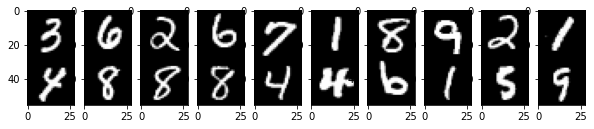

In [3]:
class BatchGenerator(keras.utils.Sequence):
    
    def __init__(self, x_set, n, batch_size):
        self.xs = [x_set for _ in range(n)]
        self.batch_size = batch_size
        self.on_epoch_end() # shuffle inputs

    def __len__(self):
        return math.ceil(len(self.xs[0])/self.batch_size)

    def __getitem__(self, idx):
        xs = []
        for x in self.xs:
            batch = x[idx*self.batch_size : (idx+1)*self.batch_size]
            a = np.array(batch)
            xs.append(np.array(batch))
        ys = np.concatenate(xs, axis=1)
        return xs, ys

    def on_epoch_end(self):
        self.xs = [np.random.permutation(x) for x in self.xs]

(X_train, _), (X_test, _) = keras.datasets.mnist.load_data() # load
X_train, X_test = tf.reshape(X_train, (-1,nrows,ncols,1)), tf.reshape(X_test, (-1,nrows,ncols,1)) # reshape
X_train, X_test = tf.cast(X_train, 'float32') / 255., tf.cast(X_test, 'float32') / 255.  # MinMax scale
train_gen = BatchGenerator(X_train, nencoders, batch_size)
test_gen  = BatchGenerator(X_test, nencoders, batch_size)

fig, axs = plt.subplots(1, 10, figsize=(10,2))
for ax, (xs, ys) in zip(axs, train_gen):
    ax.imshow(tf.reshape(ys[0], (nencoders*nrows, ncols)), vmin=vmin, vmax=vmax) # select first truth element of batch

### 2. Create model
* Encoders use their individual set of weights, weights are **not** shared.
* Concatenate latent spaces and feed to (larger) decoder.

In [4]:
def build_encoder(latent_dims):
    return keras.Sequential([
        keras.layers.Input(shape=(nrows,ncols,1)),
        keras.layers.Conv2D(filters=8, kernel_size=4, strides=2, padding='same', activation='sigmoid', use_bias=False),
        keras.layers.Conv2D(filters=16, kernel_size=4, strides=2, padding='same', activation='sigmoid', use_bias=False),
        keras.layers.Flatten(),
        keras.layers.Dense(units=latent_dims, activation='linear', use_bias=False),
    ])

def build_decoder(latent_dims, nencoders):
    return keras.Sequential([
        keras.layers.Input(shape=(nencoders*latent_dims,)),
        keras.layers.Dense(units=nencoders*nrows//4*ncols//4*16, activation='sigmoid', use_bias=False), # add units to avoid bottleneck forming here.
        keras.layers.Reshape(target_shape=(nencoders*nrows//4,ncols//4,16)),      # .. reshape those units into channel dimension.
        keras.layers.Conv2DTranspose(filters=8, kernel_size=4, strides=2, padding='same', activation='sigmoid', use_bias=False),
        keras.layers.Conv2DTranspose(filters=1, kernel_size=4, strides=2, padding='same', activation='linear', use_bias=False),
    ])

encoders = [build_encoder(latent_dims) for _ in range(nencoders)]   # add n individual encoders
decoder  = build_decoder(latent_dims, nencoders)
latent_dims_combined = keras.layers.concatenate([e(e.inputs) for e in encoders])
micae = keras.models.Model([e.inputs for e in encoders], decoder(latent_dims_combined))
micae.compile(loss='mse', optimizer='adam')

### 3. Train model

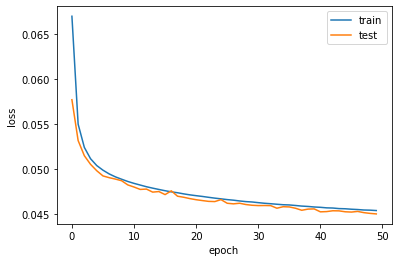

In [5]:
history = micae.fit(train_gen, validation_data=test_gen, epochs=nepochs, batch_size=batch_size, verbose=0)
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend()

### 4. Transform into and from latent space

Z_mean = 0.9758986234664917, Z_var = 57.88007354736328


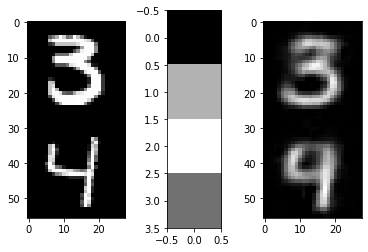

In [6]:
xs, ys = test_gen[expl_batch]
encoder_model = keras.models.Model([e.inputs for e in encoders], latent_dims_combined)
Z = encoder_model.predict(xs)
print(f"Z_mean = {Z.mean()}, Z_var = {Z.var()}")
X_pred = decoder(Z)

fig, ax = plt.subplots(ncols=3, nrows=1)
ax[0].imshow(tf.reshape(ys[expl_idx],(nencoders*nrows, ncols)), vmin=vmin, vmax=vmax)
ax[1].imshow(tf.reshape(Z[expl_idx], (-1, 1)))
ax[2].imshow(tf.reshape(X_pred[expl_idx], (nencoders*nrows, ncols)), vmin=vmin, vmax=vmax)

### 5. Interpolation in latent space
* The latent components of the different encoders vary relatively independently.
* Notice that the decoder **learnt** to correlate latent neurons with only a part of its output layer.

In [11]:
from ipywidgets import interactive
import ipywidgets as widgets

def f(**kwargs):
    z = np.array(list(kwargs.values()), dtype='float32')
    x_pred = decoder(z.reshape(1,-1))
    plt.figure(2)
    plt.imshow(tf.reshape(x_pred,(nencoders*nrows, ncols)), vmin=vmin, vmax=vmax)

scores = Z[expl_idx]

sliders = {f"PC{i+1}": widgets.FloatSlider(min=tf.reduce_min(z),max=tf.reduce_max(z),value=score) 
           for (i,score), z in zip(enumerate(scores), tf.transpose(Z))}

interactive(f, **sliders)
ix_plot = interactive(f, **sliders)
output = ix_plot.children[-1]
output.layout.height = '250px'
ix_plot

interactive(children=(FloatSlider(value=-7.772113800048828, description='PC1', max=7.851104259490967, min=-10.…

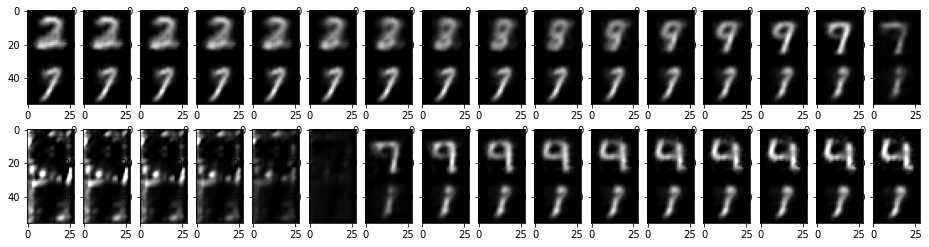

In [8]:
steps = 16
z_vars = [np.linspace(np.min(ax), np.max(ax), steps) for ax in tf.transpose(Z)] # interpolation range
fig, axs = plt.subplots(ncols=steps, nrows=latent_dims, figsize=(steps, latent_dims*2))

for i in range(latent_dims):
    for j in range(steps):
        z = np.zeros_like(Z[expl_idx])
        z[i] = z_vars[i][j]
        x_pred = decoder.predict(z.reshape(1, -1))
        ax = list(axs.flat)[j+i*j] if latent_dims==1 else axs[i, j]
        ax.imshow(tf.reshape(x_pred, (nencoders*nrows, ncols)), vmin=vmin, vmax=vmax)

### 6. Properties of MICAE
* Some components seem to be largely decorrelated
* Overall, the latent neurons' activations are correlated.

Cov of latent activations:
 tf.Tensor(
[[24.772253  -7.3029284 -2.6355073  2.7425597]
 [-7.3029284 29.680662  -3.9247293  3.5781472]
 [-2.6355073 -3.9247293 33.78983    2.4411266]
 [ 2.7425597  3.5781472  2.4411266 29.82391  ]], shape=(4, 4), dtype=float32)


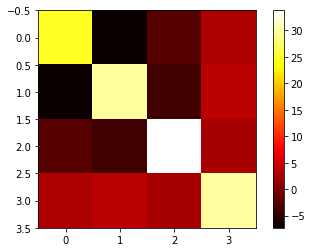

In [9]:
nsamples = len(Z)
fig, ax = plt.subplots()
Z = tf.subtract(Z, tf.reduce_mean(Z, axis=0))
Z_cov = (tf.transpose(Z) @ Z) / (nsamples-1)
print("Cov of latent activations:\n", Z_cov)
plt.imshow(Z_cov, cmap='hot')
plt.colorbar();

### 7. Calculate MSE

In [10]:
print("MSE: ", micae.evaluate(test_gen))

313/313 [==============================] - 0s 2ms/step - loss: 0.0450
MSE:  0.04503422975540161
